In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_image_batched_inference.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [ ]:
from PIL import Image
import requests
from io import BytesIO
from sam3.train.data.collator import collate_fn_api as collate
from sam3.train.utils.train_utils import copy_data_to_device

In [ ]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

sam3_root = "/home/kalyanv/sam3"

# Utilities

## Plotting

This section contains simple utilities to plot masks and bounding masks on top of an image

In [ ]:
import sys

sys.path.append(f"{sam3_root}/examples")

from utils import plot_mask, plot_bbox, plot_results, COLORS
import matplotlib.pyplot as plt

## Batching

This section contains some utility functions to create datapoints. They are optional, but give some good indication on how they should be created

In [ ]:
from sam3.train.data.sam3_image_dataset import InferenceMetadata, FindQueryLoaded, Image as SAMImage, Datapoint
from typing import List

GLOBAL_COUNTER = 1
def create_empty_datapoint():
    """ A datapoint is a single image on which we can apply several queries at once. """
    return Datapoint(find_queries=[], images=[])

def set_image(datapoint, pil_image):
    """ Add the image to be processed to the datapoint """
    w,h = pil_image.size
    datapoint.images = [SAMImage(data=pil_image, objects=[], size=[h,w])]

def add_text_prompt(datapoint, text_query):
    """ Add a text query to the datapoint """

    global GLOBAL_COUNTER
    # in this function, we require that the image is already set.
    # that's because we'll get its size to figure out what dimension to resize masks and boxes
    # In practice you're free to set any size you want, just edit the rest of the function
    assert len(datapoint.images) == 1, "please set the image first"

    w, h = datapoint.images[0].size
    datapoint.find_queries.append(
        FindQueryLoaded(
            query_text=text_query,
            image_id=0,
            object_ids_output=[], # unused for inference
            is_exhaustive=True, # unused for inference
            query_processing_order=0,
            inference_metadata=InferenceMetadata(
                coco_image_id=GLOBAL_COUNTER,
                original_image_id=GLOBAL_COUNTER,
                original_category_id=1,
                original_size=[w, h],
                object_id=0,
                frame_index=0,
            )
        )
    )
    GLOBAL_COUNTER += 1
    return GLOBAL_COUNTER - 1

def add_visual_prompt(datapoint, boxes:List[List[float]], labels:List[bool], text_prompt="visual"):
    """ Add a visual query to the datapoint.
    The bboxes are expected in XYXY format (top left and bottom right corners)
    For each bbox, we expect a label (true or false). The model tries to find boxes that ressemble the positive ones while avoiding the negative ones
    We can also give a text_prompt as an additional hint. It's not mandatory, leave it to "visual" if you want the model to solely rely on the boxes.

    Note that the model expects the prompt to be consistent. If the text reads "elephant" but the provided boxe points to a dog, the results will be undefined.
    """

    global GLOBAL_COUNTER
    # in this function, we require that the image is already set.
    # that's because we'll get its size to figure out what dimension to resize masks and boxes
    # In practice you're free to set any size you want, just edit the rest of the function
    assert len(datapoint.images) == 1, "please set the image first"
    assert len(boxes) > 0, "please provide at least one box"
    assert len(boxes) == len(labels), f"Expecting one label per box. Found {len(boxes)} boxes but {len(labels)} labels"
    for b in boxes:
        assert len(b) == 4, f"Boxes must have 4 coordinates, found {len(b)}"

    labels = torch.tensor(labels, dtype=torch.bool).view(-1)
    if not labels.any().item() and text_prompt=="visual":
        print("Warning: you provided no positive box, nor any text prompt. The prompt is ambiguous and the results will be undefined")
    w, h = datapoint.images[0].size
    datapoint.find_queries.append(
        FindQueryLoaded(
            query_text=text_prompt,
            image_id=0,
            object_ids_output=[], # unused for inference
            is_exhaustive=True, # unused for inference
            query_processing_order=0,
            input_bbox=torch.tensor(boxes, dtype=torch.float).view(-1,4),
            input_bbox_label=labels,
            inference_metadata=InferenceMetadata(
                coco_image_id=GLOBAL_COUNTER,
                original_image_id=GLOBAL_COUNTER,
                original_category_id=1,
                original_size=[w, h],
                object_id=0,
                frame_index=0,
            )
        )
    )
    GLOBAL_COUNTER += 1
    return GLOBAL_COUNTER - 1

# Loading

First we load our model

In [ ]:
from sam3 import build_sam3_image_model

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
checkpoint_path = f"{sam3_root}/assets/checkpoints/sam3_image_model_only.pt"
model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path).cuda()

Then our validation transforms

In [ ]:
from sam3.train.transforms.basic_for_api import ComposeAPI, RandomResizeAPI, ToTensorAPI, NormalizeAPI

from sam3.model.position_encoding import PositionEmbeddingSine
transform = ComposeAPI(
    transforms=[
        RandomResizeAPI(sizes=1008, max_size=1008, square=True, consistent_transform=False),
        ToTensorAPI(),
        NormalizeAPI(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


And finally our postprocessor

In [ ]:
from sam3.train.eval.postprocessors import PostProcessImage
postprocessor = PostProcessImage(
    max_dets_per_img=-1,       # if this number is positive, the processor will return topk. For this demo we instead limit by confidence, see below
    iou_type="segm",           # we want masks
    use_original_sizes=True,   # our masks should be resized to the image size
    convert_mask_to_rle=False, # the postprocessor supports efficient conversion to RLE format. In this demo we prefer the binary format for easy plotting
    detection_threshold=0.5,   # Only return confident detections
    to_cpu=False,
)

# Inference

For inference, we proceed as follows:
- Create each datapoint one by one, using the functions above. Each query that we make will give us a unique id, which is then used after post-processing to retrieve the results
- Each datapoint must be transformed according to are pre-processing transforms (basically resize to 1008x1008, normalize)
- We then collate all datapoints into a batch and forward it to the model

In [ ]:
# Image 1, we'll use two text prompts

img1 = Image.open(BytesIO(requests.get("http://images.cocodataset.org/val2017/000000077595.jpg").content))
datapoint1 = create_empty_datapoint()
set_image(datapoint1, img1)
id1 = add_text_prompt(datapoint1, "cat")
id2 = add_text_prompt(datapoint1, "laptop")

datapoint1 = transform(datapoint1)

In [ ]:
# Image 2, one text prompt, some visual prompt
img2 = Image.open(BytesIO(requests.get("http://images.cocodataset.org/val2017/000000136466.jpg").content))

# img2 = Image.open(f"{sam3_root}/assets/images/test_image.jpg")
datapoint2 = create_empty_datapoint()
set_image(datapoint2, img2)
id3 = add_text_prompt(datapoint2, "pot")
# we trying to find the dials on the oven. Let's give a positive box
id4 = add_visual_prompt(datapoint2, boxes=[[ 59, 144,  76, 163]], labels=[True])
# Let's also get the oven start/stop button
id5 = add_visual_prompt(datapoint2, boxes=[[ 59, 144,  76, 163],[ 87, 148, 104, 159]], labels=[True, True])
# Next, let's try to find the pot handles. With the text prompt "handle" (vague on purpose), the model also finds the oven's handles
# We could make the text query more precise (try it!) but for this example, we instead want to leverage a negative prompt
# First, let's see what happens with just the text prompt
id6 = add_text_prompt(datapoint2, "handle")
# now the same but adding the negative prompt
id7 = add_visual_prompt(datapoint2, boxes=[[ 40, 183, 318, 204]], labels=[False], text_prompt="handle")

datapoint2 = transform(datapoint2)

In [ ]:
# Collate then move to cuda
batch = collate([datapoint1, datapoint2], dict_key="dummy")["dummy"]
batch = copy_data_to_device(batch, torch.device("cuda"), non_blocking=True)

In [ ]:
# Forward. Note that the first forward will be very slow due to compilation
output = model(batch)

In [ ]:
processed_results = postprocessor.process_results(output, batch.find_metadatas)

# Plotting

In [ ]:
plot_results(img1, processed_results[id1])

In [ ]:
plot_results(img1, processed_results[id2])

In [ ]:
# this is the prompt "pot"
plot_results(img2, processed_results[id3])

findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


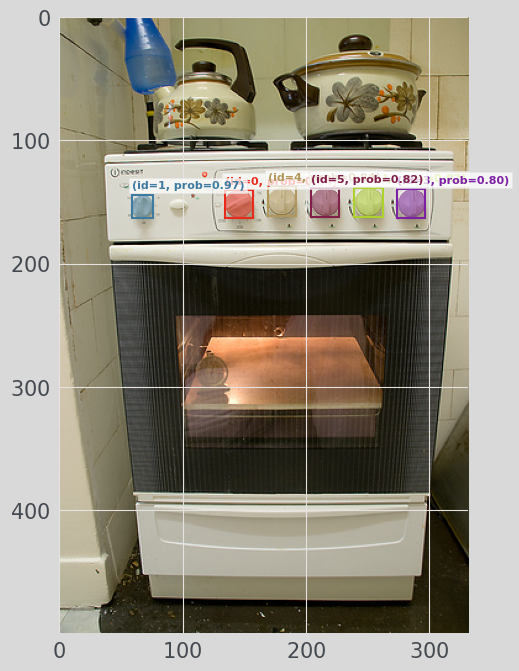

In [ ]:
# This is the result of the visual prompt. We prompted for the left-most dial, the model correctly found all of them.
plot_results(img2, processed_results[id4])

findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


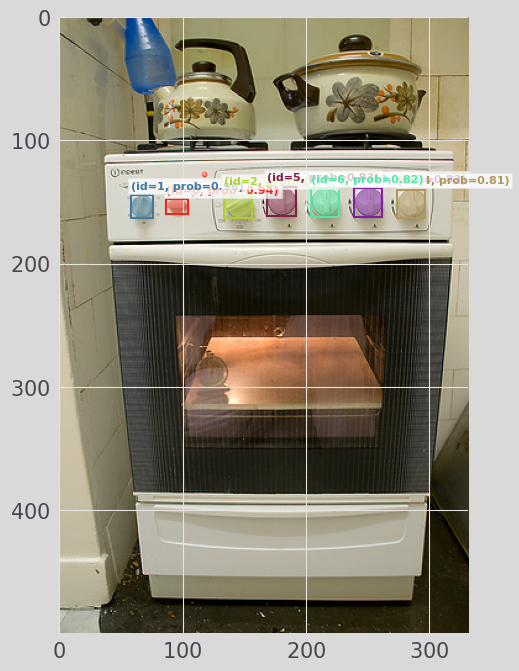

In [ ]:
# This is the same as above, but we also added a prompt for the on/off switch
plot_results(img2, processed_results[id5])

In [ ]:
# this is the prompt "handle". Notice the oven handles that we want to remove
plot_results(img2, processed_results[id6])

In [ ]:
# This time we added the negative prompt for the oven handle and the unwanted boxes are gone
plot_results(img2, processed_results[id7])